In [12]:
import numpy as np
from pc_kriging import PC_Kriging
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize
import pandas as pd
from numpy import genfromtxt
import pickle

from scipy.special import eval_legendre, eval_hermitenorm
import scipy.special

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def LinearNorm(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))


def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [array]
    dist=PCK1.distance(x.reshape(1,-1),xn)
    return np.argmin(dist)

In [2]:
# #ground truth function----------------------------------------------------
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

In [26]:
config = {"pol_type": ['hermite', 'hermite']}   #design variables following normal distribution
PCK1 = PC_Kriging(config)
PCK_loo = PC_Kriging(config)    # for LOOCV with same 'config' as specified in the original model

In [27]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v = 5/2
    N = len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

## Initial training 

In [211]:
### Generating training points
# function = gfun_53   #choose the ground truth function
# dim = 2       # dimensionality
# n = 10       # number of initial sampling

# #------------------------------------------------------------
# xn = np.zeros((int(n), dim))      #normalized training points
# xr = np.zeros((int(n), dim))      #scaled training points
# yn = np.zeros((int(n)))           #observations

# mean_loo = np.zeros(len(xn))
# var_loo = np.zeros(len(xn))

#------------------------------------------------------------

# #initial design of experiments (LHS) --------------------------------
# x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
# x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

# # Check the variables limits for space-filling distribution (NORMAL DISTRIBUTIONS???)
# Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
#                                  'x2':[-1, 1],} , 
#                                   num_samples = n )
# #------------------------------------------------------------
# xn[:,0] = Xdoe['x1']
# xn[:,1] = Xdoe['x2']
# xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
# xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

# yn = function(xr)[0]

In [125]:
function = gfun_53   #choose the ground truth function
dim = 2       # dimensionality

ntest = 5000  # test points

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

YN = function(XR)[0]

# Active training - U - 1 LS

In [279]:
number_experiments = 1
number_active_points = 30

results_file = 'AT_U_LS1_' + str(number_active_points)   # index for results files

for experiments in range(number_experiments):
    print('Experiment: ', experiments+1 , '------------------------------------------------------------' )
    
    ActiveTrain = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }

    #initial design of experiments (LHS) --------------------------------

    n = 10       # number of initial sampling

    xn = np.zeros((int(n), dim))      #normalized training points
    xr = np.zeros((int(n), dim))      #scaled training points
    yn = np.zeros((int(n)))           #observations

    mean_loo = np.zeros(len(xn))
    var_loo = np.zeros(len(xn))

    x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
    x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

    # Check the variables limits for space-filling distribution
    Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                     'x2':[-1, 1],} , 
                                      num_samples = n )
    #------------------------------------------------------------
    xn[:,0] = Xdoe['x1']
    xn[:,1] = Xdoe['x2']
    xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
    xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

    yn = function(xr)[0]

    for points in range(number_active_points):

        ModelName = 'PCK' + str(len(xn))

        ModelName = PC_Kriging(config)

        # Selecting the best model (length and order) 
        # kernel hyperparameters------------------------------
        v = 5/2
        #n = 11 
        #truncation term-------------------------------------
        p_max = 5  #for each variable → same truncation , degree of expansion

        mse_results = np.zeros(p_max-1)
        opt_length_it = np.zeros(p_max-1)

        mean_loo = np.zeros(len(xn))
        var_loo = np.zeros(len(xn))
        eloo_results = np.zeros(p_max-1)

        dist = PCK1.distance(xr, xr)
        lmax = np.max(dist)
        lmin = np.min(dist[dist!=0])

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):
            results = dict()
            bounds = [(lmin, lmax)]
            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors

            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar1 = PCK1.train (xn, yn, p, theta) 
            mean0, var0 = PCK1.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar1 = ModelName.train (xn, yn, int(opt+1), theta_opt) 

        ## Pool of samples
        MCS_samples = 100000

        MCinputs_norm = np.zeros((int(MCS_samples), dim))
        MCinputs = np.zeros((int(MCS_samples), dim))

        MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
        MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

        MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
        MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

        # ---------------------------------------------------
        ymc = function(MCinputs)[0]  
        fail_samples = np.sum(ymc < 0 )
        Pf_ref = fail_samples/MCS_samples

        meanMC, varMC = ModelName.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO = np.sum(np.asarray(meanMC) < 0 )
        fail_prob_SUMO = fail_samples_SUMO / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO ) / (fail_prob_SUMO * MCS_samples) )


        print('Degree', int(opt+1), 'e_LOO', np.min(eloo_results) , 'Pf', fail_prob_SUMO , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain[str(len(xn))+'points'] = ModelName , fail_prob_SUMO , cov_pf , np.min(eloo_results), np.min(mse_results)

        ### Evaluating new points
        U_f = U_function(meanMC.reshape(-1), varMC.reshape(-1))
        xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
        xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)
        yn = function(xr)[0] #Only one point needs to be evaluated here

        print('number of training points: ', len(xn))
    
    filename = results_file + '_batch_' + str(experiments+1) + '.sav'
    pickle.dump(ActiveTrain, open(filename, 'wb'))

Experiment:  1 ------------------------------------------------------------


C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Degree 2 e_LOO 0.00022862672694264654 Pf 0.09381 CoV 0.00980
number of training points:  11
Degree 3 e_LOO 0.009262737948490338 Pf 0.08871 CoV 0.01010
number of training points:  12
Degree 3 e_LOO 0.0020724498722875105 Pf 0.08391 CoV 0.01040
number of training points:  13
Degree 1 e_LOO 0.0016537443891374859 Pf 0.01116 CoV 0.02980
number of training points:  14


C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in double_scalars


Degree 1 e_LOO 0.005155134445839321 Pf 0.0 CoV inf
number of training points:  15
Degree 1 e_LOO 0.006566356240120227 Pf 0.02992 CoV 0.01800
number of training points:  16
Degree 2 e_LOO 0.003926011471611352 Pf 0.02478 CoV 0.01980
number of training points:  17
Degree 1 e_LOO 5.502745301641961e-06 Pf 0.00915 CoV 0.03290
number of training points:  18
Degree 2 e_LOO 0.0011549385913838936 Pf 0.01041 CoV 0.03080
number of training points:  19
Degree 1 e_LOO 0.0007414545191745861 Pf 0.01414 CoV 0.02640
number of training points:  20
Degree 2 e_LOO 0.0005990376117512672 Pf 0.00621 CoV 0.04000
number of training points:  21
Degree 1 e_LOO 0.001486831950160354 Pf 0.00971 CoV 0.03190
number of training points:  22
Degree 1 e_LOO 0.00040893698015445287 Pf 0.01558 CoV 0.02510
number of training points:  23
Degree 1 e_LOO 0.0005411553325627003 Pf 0.01617 CoV 0.02470
number of training points:  24
Degree 2 e_LOO 0.003832789029713891 Pf 0.01471 CoV 0.02590
number of training points:  25
Degree 1 e_

In [286]:
#results file 'KEY: #points'{ Surrogate , Pf, CoV_Pf , eLoo , mse } 
ActiveTrain['39points']

(<pc_kriging.PC_Kriging at 0x291f578c248>,
 0.03295,
 0.017131553828259753,
 0.0005428005421573985,
 0.1286410739910592)

# Active training - EFF - 1 LS

In [277]:
number_experiments = 1
number_active_points = 30

results_file = 'AT_EFF_LS1_' + str(number_active_points)    # index for results files

for experiments in range(number_experiments):
    print('Experiment: ', experiments+1 , '------------------------------------------------------------' )
    
    ActiveTrain = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }

    #initial design of experiments (LHS) --------------------------------

    n = 10       # number of initial sampling

    xn = np.zeros((int(n), dim))      #normalized training points
    xr = np.zeros((int(n), dim))      #scaled training points
    yn = np.zeros((int(n)))           #observations

    mean_loo = np.zeros(len(xn))
    var_loo = np.zeros(len(xn))

    x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
    x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

    # Check the variables limits for space-filling distribution
    Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                     'x2':[-1, 1],} , 
                                      num_samples = n )
    #------------------------------------------------------------
    xn[:,0] = Xdoe['x1']
    xn[:,1] = Xdoe['x2']
    xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
    xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

    yn = function(xr)[0]

    for points in range(number_active_points):

        ModelName = 'PCK' + str(len(xn))

        ModelName = PC_Kriging(config)

        # Selecting the best model (length and order) 
        # kernel hyperparameters------------------------------
        v = 5/2
        
        #truncation term-------------------------------------
        p_max = 5  #for each variable → same truncation , degree of expansion

        mse_results = np.zeros(p_max-1)
        opt_length_it = np.zeros(p_max-1)

        mean_loo = np.zeros(len(xn))
        var_loo = np.zeros(len(xn))
        eloo_results = np.zeros(p_max-1)

        dist = PCK1.distance(xr, xr)
        lmax = np.max(dist)
        lmin = np.min(dist[dist!=0])

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):
            results = dict()
            bounds = [(lmin, lmax)]
            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors

            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar1 = PCK1.train (xn, yn, p, theta) 
            mean0, var0 = PCK1.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar1 = ModelName.train (xn, yn, int(opt+1), theta_opt) 

        ## Pool of samples
        MCS_samples = 100000

        MCinputs_norm = np.zeros((int(MCS_samples), dim))
        MCinputs = np.zeros((int(MCS_samples), dim))

        MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
        MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

        MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
        MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

        # ---------------------------------------------------
        ymc = function(MCinputs)[0]  
        fail_samples = np.sum(ymc < 0 )
        Pf_ref = fail_samples/MCS_samples

        meanMC, varMC = ModelName.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO = np.sum(np.asarray(meanMC) < 0 )
        fail_prob_SUMO = fail_samples_SUMO / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO ) / (fail_prob_SUMO * MCS_samples) )


        print('Degree', int(opt+1), 'e_LOO', np.min(eloo_results) , 'Pf', fail_prob_SUMO , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain[str(len(xn))+'points'] = ModelName , fail_prob_SUMO , cov_pf , np.min(eloo_results), np.min(mse_results)

        ### Evaluating new points
        eff1 = EFF(meanMC.reshape(-1),varMC.reshape(-1) , 0 )  #(mean, variance, target)  
        
        xr = np.append(xr, MCinputs[np.argmax(eff1)]).reshape(-1,2)
        xn = np.append(xn, MCinputs_norm[np.argmax(eff1)]).reshape(-1,2)
        yn = function(xr)[0] #Only one point needs to be evaluated here

        print('number of training points: ', len(xn))
    
    filename = results_file + '_batch_' + str(experiments+1) + '.sav'
    pickle.dump(ActiveTrain, open(filename, 'wb'))    #saving dictionary after each experiment

Experiment:  1 ------------------------------------------------------------


C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Degree 1 e_LOO 0.0004912362339917138 Pf 0.08379 CoV 0.01050
number of training points:  11
Degree 2 e_LOO 0.0006025132792846928 Pf 0.02823 CoV 0.01860
number of training points:  12
Degree 1 e_LOO 0.016956617049098465 Pf 0.00812 CoV 0.03500
number of training points:  13
Degree 1 e_LOO 0.01959258945101286 Pf 0.00476 CoV 0.04570
number of training points:  14
Degree 1 e_LOO 0.003228953517734414 Pf 0.03244 CoV 0.01730
number of training points:  15
Degree 1 e_LOO 0.0005263720037712709 Pf 0.02236 CoV 0.02090
number of training points:  16
Degree 2 e_LOO 0.0026713837264461353 Pf 0.01955 CoV 0.02240
number of training points:  17
Degree 2 e_LOO 0.013252602225659958 Pf 0.02903 CoV 0.01830
number of training points:  18
Degree 2 e_LOO 9.006981474284996e-06 Pf 0.03212 CoV 0.01740
number of training points:  19
Degree 2 e_LOO 0.0008903586285228474 Pf 0.04333 CoV 0.01490
number of training points:  20
Degree 2 e_LOO 0.00025702527819792794 Pf 0.04166 CoV 0.01520
number of training points:  21
Deg

<IPython.core.display.Javascript object>


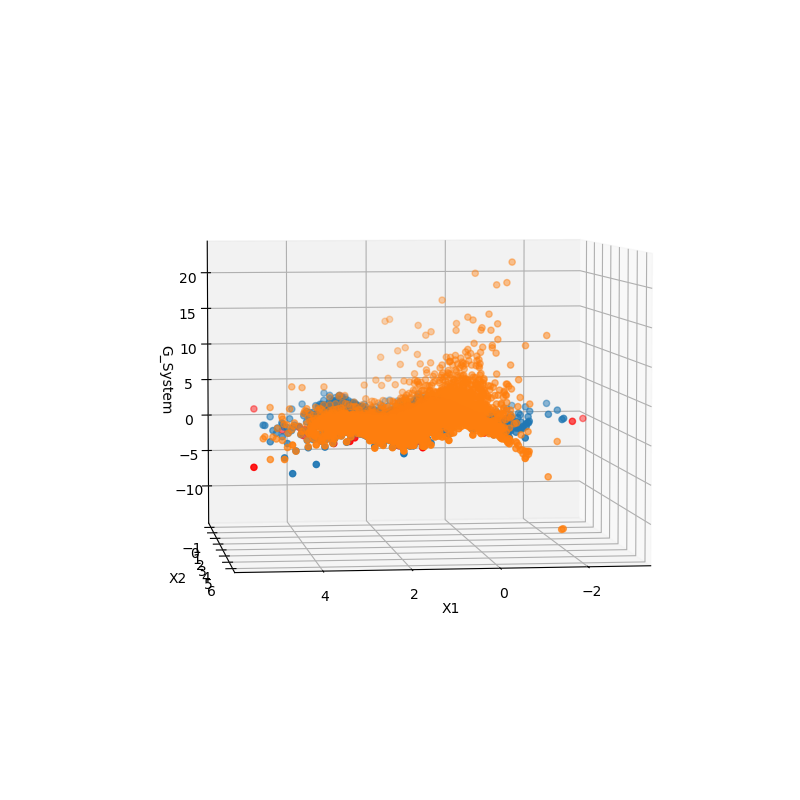

Text(0.5, 0, 'G_System')

In [280]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN)
ax.scatter(XR[:,0],XR[:,1], mean0)             #plotting the last trained surrogate
ax.scatter(xr[:,0],xr[:,1], yn, color='red')   #observation points 
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('G_System')

In [229]:
#load model
filename = 'testLOO_AT_U_LS1.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [232]:
loaded_model['10points']

(<pc_kriging.PC_Kriging at 0x291f51d34c8>, 0.01418, 0.026366998649287127)

# "Manual" active training

In [57]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
v = 5/2
#n = 11 
#truncation term-------------------------------------
p_max = 4  #for each variable → same truncation , degree of expansion
mse_results = np.zeros(p_max-1)
opt_length_it = np.zeros(p_max-1)

dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

for p in range(1, p_max):
    results = dict()
    bounds = [(lmin, lmax)]
    results['shgo'] = optimize.shgo(L_Object, bounds)
    opt_length = results['shgo']['x'][0]
    
    theta = np.array([opt_length, v])

    modelpar1 = PCK1.train (xn, yn, p, theta) 
    mean0, var0 = PCK1.predict_fast(XN)    # mean, variance
    
    mse = np.mean ((YN - mean0)**2)
    mse_results[p-1] = mse
    opt_length_it[p-1] = opt_length
    print('Degree', p, 'MSE', "%.2f" % round(mse, 2))
    
opt = np.argmin(mse_results) 
modelpar1 = PCK1.train (xn, yn, int(opt+1), np.array([opt_length_it[opt], v])) 

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Degree 1 MSE 0.48
Degree 2 MSE 0.71
Degree 3 MSE 1.18


MCS and evaluating U function

In [47]:
MCS_samples = 100000

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

meanMC, varMC = PCK1.predict_fast(MCinputs_norm)    # mean, variance
fail_samples_SUMO = np.sum(np.asarray(meanMC) < 0 )
fail_prob_SUMO = fail_samples_SUMO / MCS_samples

print(Pf_ref, fail_prob_SUMO)

0.03093 0.01324


### Evaluating U function and adding training point

In [72]:
U_f = U_function(meanMC.reshape(-1), varMC.reshape(-1))
#np.argmax(U_f)
#MCinputs_norm[np.argmin(U_f)]
## Add fancy plot
plt.plot(U_f)
ax.set_yscale('log')
#plt.plot(varMC)

xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)

yn = function(xr)[0] #Only one point needs to be evaluated here

print('number of training points: ', len(xn))

NameError: name 'meanMC' is not defined

## Newly created functions

In [ ]:
def predict_pm (XN):
        ff0 = time.time()
        Rn = PCK1.matern(PCK1.doe, PCK1.doe, PCK1.hyperp[0], PCK1.hyperp[1])
        ff1 = time.time()
        Rn_inv = np.linalg.inv(Rn)
        ff2 = time.time()
        
        size_XN = XN.shape
        mean_predict = np.zeros(size_XN[0])
        var_predict = np.zeros(size_XN[0])
    
        for i in range(size_XN[0]):
            ff22 = time.time()
            fx = PCK1.info_matrix(XN[i].reshape(1,2), PCK1.Poly_ind)
            ff3 = time.time()
            rx = matern_pm(XN[i].reshape(1,2), PCK1.doe, PCK1.hyperp[0], PCK1.hyperp[1])
            ff4 = time.time()
            
            mean1 = fx @ PCK1.coeff
            #ff5 = time.time()
            mean2 = rx @ Rn_inv @ (PCK1.observ - (PCK1.InfoMat @ PCK1.coeff))
            #ff6 = time.time()
            mean_total = mean1 + mean2
            #ff7 = time.time()
                
            ux = ( PCK1.InfoMat.T @ Rn_inv @ rx.T) - fx.T
            #ff8 = time.time()
            term1 = rx @ Rn_inv @ rx.T
            #ff9 = time.time()
            term2 = ux.T @ np.linalg.inv(PCK1.InfoMat.T @ Rn_inv @ PCK1.InfoMat) @ ux
            #ff10 = time.time()
            variance = PCK1.sigmaSQ * ( 1 - term1 + term2)
            #ff11 = time.time()
        
            mean_predict[i] = mean_total
            var_predict[i] = variance[0]
        
        print(ff1 - ff0)
        print(ff2 - ff1)
        print(ff3*10000 - ff22*10000, 'EE')
        print(ff4*10000 - ff3*10000, 'HH')
        #print(ff5*10000 - ff4*10000)
        #print(ff6*10000 - ff5*10000)
        #print(ff7*10000 - ff6*10000)
        #print(ff8*10000 - ff7*10000)
        #print(ff9*10000 - ff8*10000)
        #print(ff10*10000 - ff9*10000)
        #print(ff11*10000 - ff10*10000)
        
        return mean_predict , var_predict

In [ ]:
import math
def matern_pm(xr, xn, l, v):     
    #l, hyperparameter (length scaled)
        #matern parameter, v can be 3/2, 5/2
    
    size_xn = xn.shape
    d = np.linalg.norm(xr - xn, axis=1).reshape(1, size_xn[0])
      
    if v == 3/2:
        R = (1+ np.sqrt(3)*d/l) * np.exp(-(np.sqrt(3)*d/l))
    elif v == 5/2:
        R = ((1+ (np.sqrt(5)*d/l) + (5/3)*(d/l)**2 )* np.exp(-(np.sqrt(5)*d/l)))
        
    return R

def distance_pm(x, xk):                        #multidimensional distance between 2 samples
    d = np.zeros((len(x),len(xk)))
        
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j] + np.sqrt(np.sum((x[i]-xk[j])**2))
    return d

## Former cells

In [ ]:
#definition of input parameters----------------------------------------------

# seed=0      # fixing seed random number generator
# np.random.seed(seed)         #fixing seed random number generator

function = gfun_53   #choose the ground truth function

dim = 2       # dimensionality
n = 30       # number of initial sampling
ntest = 5000  # test points

#------------------------------------------------------------
xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))           #observations
#------------------------------------------------------------

#initial design of experiments (LHS) --------------------------------
x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

# Check the variables limits for space-filling distribution (NORMAL DISTRIBUTIONS???)
Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                 'x2':[-1, 1],} , 
                                  num_samples = n )
#------------------------------------------------------------
xn[:,0] = Xdoe['x1']
xn[:,1] = Xdoe['x2']
xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

yn = function(xr)[0]
YN = function(XR)[0]

In [ ]:
YN

In [ ]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
l = 1.00   #length scale
v = 5/2
theta = np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1= PCK1.train (xn,yn,p,theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

In [ ]:
import time
# model predictions -----------------------------------------

ntest = 100000  # test points
seed = 0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

G_VAL_SYS = function(XR)
YN = G_VAL_SYS[0]

#a0 = time.time()
#mean1, var1 = PCK1.predict(XN)
a1 = time.time()

mean2, var2 = PCK1.predict_fast(XN)
a2 = time.time()

#mse = np.mean ((YN - mean1)**2)
#print(mse)
print(mean2, var2)
print(a2-a1)

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

In [3]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v = 5/2
    N = len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

In [ ]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))
    
results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

In [ ]:
#################################################################
# FIXED VALUES --------------------------------------
# v= 5/2       #matern coefficient
p = 2        #truncation term
z = 0        #target value 

# MCS ------------------------------------------------

MCS_samples = 100

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

#################################################################
# LOOP ----------------------------------------------------------
budget = 10

Pf_SUMO = []
eff1 = np.zeros(ntest)

for j in range (1,budget): 

    # UPDATE n, xn, xr, yn
    
    n=len(xn)
    LOOCV = np.zeros(ntest)
    mean_loo = np.zeros(n)
    var_loo = np.zeros(n)

    #model evaluations -----------------
    yn = function(xr)[0]

    #selecting length scale ------------
    results = dict()
    
    dist = PCK1.distance(xn, xn)
    lmax = np.max(dist)
    lmin = np.min(dist[dist!=0])
    bounds = [(lmin, lmax)]
    
    results['shgo'] = optimize.shgo(L_Object, bounds)
    l= results['shgo']['x']
    
    if (l < lmin and l > lmax ):
        l = lmin
    
    print(l, lmin, lmax)
#     l = np.min(dist[dist!=0])     #assigning the minimum distance between two points

    theta = np.array([l,v])

    # MODEL TRAINING
    modelpar1 = PCK1.train (xn,yn,p,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean1,var1 = PCK1.predict(XN)    # mean, variance

    # LOO CV errors ###################################################
    #Generating PCK models for each reduced design of experiments 

#     for i in range (0,n):             
#         yn_loo=  np.delete(yn,[i])                              #y_n-i      leaving element i out the observations 
#         xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the inputs (xr)
#         xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the nomalized inputs (xn)

#         #training LOO
#         modelpar_loo = PCK_loo.train (xn_loo,yn_loo,p,theta)   # same (p) as specified in the original model

#         #predicting LOO
#         mean_loo[i], var_loo[i] = PCK_loo.predict(xn[i].reshape(1,-1))



#     e_loo = (yn - mean_loo)**2              #LOO CV squared errors
#     sumat = np.divide(e_loo,var_loo)        #vector (e_loo / s_loo) for each observed point


#     for k in range (0,ntest):               #variance enhancement based LOO CV erros around voronoi cells
#         voro = VoronoiCell(XR[k],xr)

#         LOOCV[k]= var_plot[k]*(1+sumat[voro])   
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []
    
    # var_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())
    #     var_MCS.append(var_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    #################################################### 
    
    #-------------------------------------- EFF
#     eff1 = EFF(np.squeeze(mean1),LOOCV,z)    #with LOO cv

    eff1 = EFF(np.squeeze(mean1),var1,z)

    maxEff = np.argmax(eff1)
    Xr_new = XR[maxEff]
    Xn_new = XN[maxEff]
    
    #-------------------------------------- U_function
# #     U_f = U_function(mean1.reshape(-1), LOOCV.reshape(-1))    #with LOO cv
#     U_f = U_function(mean1.reshape(-1), var1.reshape(-1))
    
#     minU = np.argmin(U_f)
#     Xr_new = XR[minU]   

    # adding observation and updating -----------------------------------
    xr = np.append(xr,Xr_new).reshape(-1,2)
    xn = np.append(xn,Xn_new).reshape(-1,2)
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean1)**2)
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    
    pf_error = np.abs( (Pf_ref - fail_prob_SUMO)) / Pf_ref 
    ####################################################
    print(j, 'Pf ', "%.4f" % round(fail_prob_SUMO, 4) , 'pf_error', "%.2f" % round(pf_error, 2) )
    
yn = function(xr)[0]